![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Value at Risk

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

### Task: 

Load the data and show in a single plot the cumulative log-returns of '.GDAXI' as well as an equally weighted portfolio of its constituents (all the other assets in 02_python_data.csv, excluding '.GDAXI').

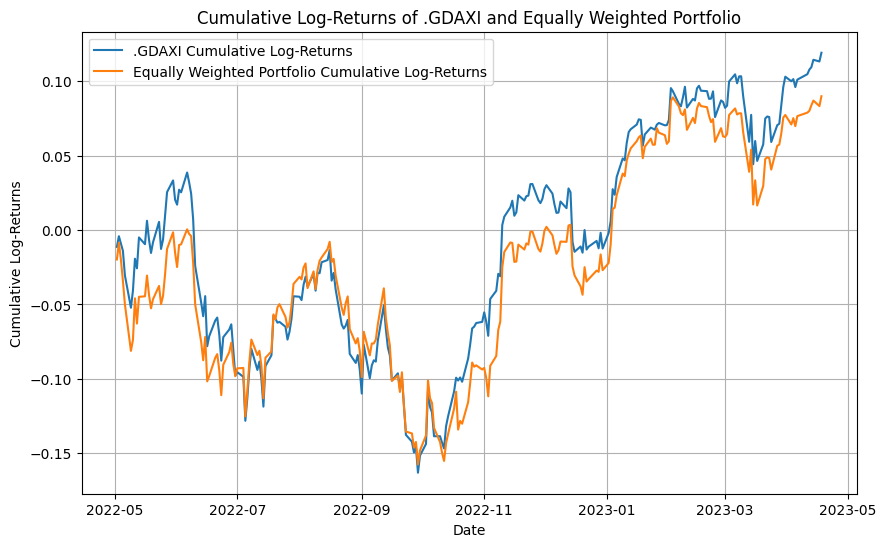

In [54]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV file
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

#logreturns of DAX
logreturns_Dax = np.log(prices['.GDAXI']) - np.log(prices['.GDAXI'].shift(1))

#cummulative logreturns:
cum_logreturns_Dax=logreturns_Dax.cumsum()

#dataframe of mean of all constituents (equally weighted portfolio of the rest):
constituents=prices.drop(columns='.GDAXI')
constituents_mean=constituents.mean(axis=1)

#logreturns of constituents:
logreturns_constituents_mean=(np.log(constituents_mean)-np.log(constituents_mean.shift(1))).dropna()
constituents_logreturns = np.log(prices.drop(columns='.GDAXI') / prices.drop(columns='.GDAXI').shift(1))

#cumulative log-returns
gdaxi_cumulative_returns = logreturns_Dax.cumsum()
constituents_cumulative_returns = logreturns_constituents_mean.cumsum()

#Plot the cumulative log-returns
plt.figure(figsize=(10, 6))
plt.plot(gdaxi_cumulative_returns.index, gdaxi_cumulative_returns, label='.GDAXI Cumulative Log-Returns')
plt.plot(constituents_cumulative_returns.index, constituents_cumulative_returns, label='Equally Weighted Portfolio Cumulative Log-Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.title('Cumulative Log-Returns of .GDAXI and Equally Weighted Portfolio')
plt.legend()
plt.grid(True)
plt.show()



### Task: 

We now want to compare the risk of **both** portfolios from the previous task ('.GDAXI and the equally weighted portfolio'). To do so, calculate the 95% 1-day [Value at Risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk), using:

* Historical simulation,
* the Parametric method,
* Monte Carlo simulation.

Add all values to a data frame and `display()`

In [55]:
from scipy import stats

#Variablse
confidence_level=0.95
alpha = stats.norm.ppf(confidence_level)
Nsim = 10000

# Historical Simulation:
def historical_simulation(portfolio):
    return np.percentile(portfolio, 100 * (1 - confidence_level))

#Calculate Values
hist_sim_GDAXI=historical_simulation(gdaxi_cumulative_returns.dropna())
hist_sim_rest=historical_simulation(constituents_cumulative_returns)

#Add Values to dataframe
compar_df = pd.DataFrame({'Historical Simulation': [hist_sim_GDAXI, hist_sim_rest]}, index=['.GDAXI', 'Equal Weighted Portfolio'])

In [56]:
#Variablse
confidence_level=0.95
alpha = stats.norm.ppf(confidence_level)
Nsim = 10000

# Parametric Method
def parametric_method(portfolio):
    mean = portfolio.mean()
    std = portfolio.std()
    return -mean - alpha * std  

#Calculate Values
param_GDAXI=parametric_method(gdaxi_cumulative_returns)
param_rest=parametric_method(constituents_cumulative_returns)

#Add Values to Dataframe
compar_df['Parametric'] = [param_GDAXI, param_rest]  

In [57]:
#Variablse
confidence_level=0.95
alpha = stats.norm.ppf(confidence_level)
Nsim = 10000

#Monte Carlo Simulation
def monte_carlo_var(portfolio):
    mean = portfolio.mean()
    std = portfolio.std()
    simulated_returns = np.random.normal(mean, std, Nsim)
    return np.percentile(simulated_returns, 100 * (1 - confidence_level))

#Calculate Values
MC_GDAXI=monte_carlo_var(gdaxi_cumulative_returns)
MC_rest=monte_carlo_var(constituents_cumulative_returns)

#Add Values to Dataframe
compar_df['Monte Carlo'] = [MC_GDAXI, MC_rest]  

display(compar_df)

,Historical Simulation,Parametric,Monte Carlo
.GDAXI,-0.127052,-0.110549,-0.128024
Equal Weighted Portfolio,-0.133706,-0.086923,-0.136965


### Task: 

In order to visualize the VaR results we focus only on '.GDAXI' (you can create `plt.subplots()` for the equally weighted portfolio if you like). In the plot:

1. Plot a histogram of the returns
2. Add a line plot of the normal distribution (parameterized to the returns)
3. Add indicators for the 3 VaRs (vertical lines or annotations)

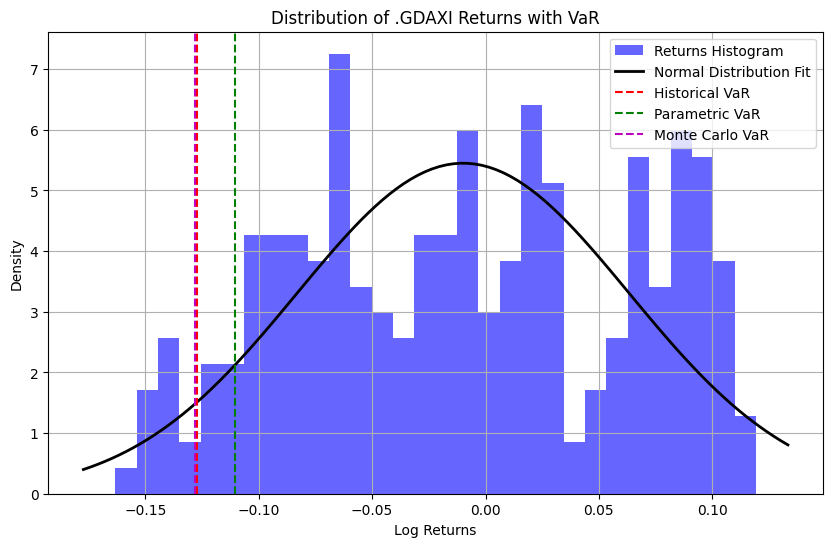

In [66]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Plot histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(cum_logreturns_Dax, bins=30, density=True, alpha=0.6, color='b', label='Returns Histogram')

# Fit a normal distribution to the data
mu = cum_logreturns_Dax.mean()
std = cum_logreturns_Dax.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

# Plot vertical lines for VaRs
plt.axvline(x=hist_sim_GDAXI, color='r', linestyle='--', label='Historical VaR')
plt.axvline(x=param_GDAXI, color='g', linestyle='--', label='Parametric VaR')
plt.axvline(x=MC_GDAXI, color='m', linestyle='--', label='Monte Carlo VaR')

# Add legend and labels
plt.title('Distribution of .GDAXI Returns with VaR')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
